In [1]:
import json
import torch
from huggingface_hub import hf_hub_download
from open_clip import create_model_and_transforms, get_tokenizer
from open_clip.factory import HF_HUB_PREFIX, _MODEL_CONFIGS

REPO_ID = "microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224"
LOCAL_DIR = "/home/ldrole/my_space/work/cam_phd/checkpoints/biomedclip"

# Download model weights + config once
hf_hub_download(repo_id=REPO_ID, filename="open_clip_pytorch_model.bin", local_dir=LOCAL_DIR)
hf_hub_download(repo_id=REPO_ID, filename="open_clip_config.json", local_dir=LOCAL_DIR)

print(f"Model files saved to {LOCAL_DIR}")

/usr/bmicnas03/data-biwi-01/ldrole_student/data/miniforge3/envs/inps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/bmicnas03/data-biwi-01/ldrole_student/data/miniforge3/envs/inps/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/bmicnas03/data-biwi-01/ldrole_student/data/miniforge3/envs/inps/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/bmicnas03/data-biwi-01/ldrole_student/data/miniforge3/envs/inps/lib/python

Model files saved to /home/ldrole/my_space/work/cam_phd/checkpoints/biomedclip


In [2]:
# ── Load BiomedCLIP from local files ──
LOCAL_DIR = "/home/ldrole/my_space/work/cam_phd/checkpoints/biomedclip"
MODEL_NAME = "biomedclip_local"

with open(f"{LOCAL_DIR}/open_clip_config.json", "r") as f:
    config = json.load(f)
    model_cfg = config["model_cfg"]
    preprocess_cfg = config["preprocess_cfg"]

# Register the model config so open_clip recognises it
if (not MODEL_NAME.startswith(HF_HUB_PREFIX)
    and MODEL_NAME not in _MODEL_CONFIGS
    and config is not None):
    _MODEL_CONFIGS[MODEL_NAME] = model_cfg

tokenizer = get_tokenizer(MODEL_NAME)
model, _, preprocess = create_model_and_transforms(
    model_name=MODEL_NAME,
    pretrained=f"{LOCAL_DIR}/open_clip_pytorch_model.bin",
    **{f"image_{k}": v for k, v in preprocess_cfg.items()},
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"BiomedCLIP loaded on {device}")
print(f"  Vision encoder: ViT-B/16-224")
print(f"  Text encoder:   PubMedBERT (context_length=256)")
print(f"  Preprocess:     {preprocess}")

/usr/bmicnas03/data-biwi-01/ldrole_student/data/miniforge3/envs/inps/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BiomedCLIP loaded on cuda
  Vision encoder: ViT-B/16-224
  Text encoder:   PubMedBERT (context_length=256)
  Preprocess:     Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f2eddb3ade0>
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)


### Example use of model

In [4]:
class_descriptions = [
    "A dermatoscopy image of melanoma",
    "A dermatoscopy image of melanocytic nevi",
    "A dermatoscopy image of basal cell carcinoma",
    "A dermatoscopy image of actinic keratosis",
    "A dermatoscopy image of benign keratosis",
    "A dermatoscopy image of dermatofibroma",
    "A dermatoscopy image of vascular lesion",
]

text_tokens = tokenizer(class_descriptions).to(device)       # [7, 256] int tensor
text_embeds = model.encode_text(text_tokens)                  # [7, 512]
text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
text_embeds.shape


torch.Size([7, 512])

In [6]:
from PIL import Image

img_path = "/home/ldrole/my_space/work/cam_phd/data/ham10000/HAM10000_images_part_1/ISIC_0024306.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)  # [1, 3, 224, 224]
img_embed = model.encode_image(img)                              # [1, 512]
img_embed = img_embed / img_embed.norm(dim=-1, keepdim=True)

similarities = (img_embed @ text_embeds.T).squeeze(0)  # [7]
probs = similarities.softmax(dim=0)


In [7]:
probs

tensor([0.1437, 0.1430, 0.1428, 0.1416, 0.1420, 0.1429, 0.1441],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [1]:
import pandas as pd

metadata = pd.read_csv("/home/ldrole/my_space/work/cam_phd/data/ham10000/HAM10000_metadata.csv")

# Full class names
label_map = {
    "akiec": "Actinic keratoses / Bowen's disease",
    "bcc":   "Basal cell carcinoma",
    "bkl":   "Benign keratosis-like lesions",
    "df":    "Dermatofibroma",
    "mel":   "Melanoma",
    "nv":    "Melanocytic nevi",
    "vasc":  "Vascular lesions",
}

counts = metadata["dx"].value_counts()
print("Class counts:")
print("-" * 45)
for code, n in counts.items():
    print(f"  {code:6s} ({label_map[code]:40s}): {n}")
print("-" * 45)
print(f"  {'Total':49s}: {len(metadata)}")

Class counts:
---------------------------------------------
  nv     (Melanocytic nevi                        ): 6705
  mel    (Melanoma                                ): 1113
  bkl    (Benign keratosis-like lesions           ): 1099
  bcc    (Basal cell carcinoma                    ): 514
  akiec  (Actinic keratoses / Bowen's disease     ): 327
  vasc   (Vascular lesions                        ): 142
  df     (Dermatofibroma                          ): 115
---------------------------------------------
  Total                                            : 10015


# Informed Neural Processes (INP) — Training Procedure

> **Paper:** *Towards Automated Knowledge Integration From Human-Interpretable Representations* (ICLR 2025)  
> **Repo:** `informed-meta-learning/`

The model is an **Informed Neural Process (INP)** — a meta-learning model that conditions on *context* observations and optional *side-knowledge* to predict targets. Training follows the standard Neural Process ELBO objective.

The pipeline is organised as:

| Step | Module | Description |
|------|--------|-------------|
| 1 | `config.py` / `config.toml` | Load hyperparameters |
| 2 | `dataset/` | Build datasets & dataloaders with custom collation |
| 3 | `models/inp.py` | INP forward pass (encode → sample latent → decode) |
| 4 | `models/loss.py` | ELBO loss (reconstruction + KL) |
| 5 | `models/train.py` | Training loop, evaluation, checkpointing |

## 1 — Configuration

All hyperparameters live in a `config.toml` file. The `Config` class simply unpacks them into attributes.  
Key groups: **training** (lr, epochs, beta), **data** (dataset, context sizes, noise), **architecture** (hidden dims, encoder depths), and **knowledge** (encoder type, merge strategy, dropout).

In [2]:
import sys, os, toml

REPO = "/home/ldrole/my_space/work/cam_phd/informed-meta-learning"
sys.path.insert(0, REPO)
os.chdir(REPO)

from config import Config

# Load the default config
cfg_dict = toml.load(f"{REPO}/config.toml")
config = Config(**cfg_dict)

# Show key settings
print("=== Training ===")
print(f"  project_name   : {config.project_name}")
print(f"  num_epochs     : {config.num_epochs}")
print(f"  batch_size     : {config.batch_size}")
print(f"  lr             : {config.lr}")
print(f"  beta (KL weight): {config.beta}")
print(f"  seed           : {config.seed}")

print("\n=== Data ===")
print(f"  dataset        : {config.dataset}")
print(f"  min/max context: {config.min_num_context} / {config.max_num_context}")
print(f"  num_targets    : {config.num_targets}")
print(f"  noise          : {config.noise}")
print(f"  x_sampler      : {config.x_sampler}")

print("\n=== Architecture ===")
print(f"  input_dim      : {config.input_dim}")
print(f"  output_dim     : {config.output_dim}")
print(f"  hidden_dim     : {config.hidden_dim}")
print(f"  x_transf_dim   : {config.x_transf_dim}")
print(f"  data_agg_func  : {config.data_agg_func}")

print("\n=== Knowledge ===")
print(f"  use_knowledge  : {config.use_knowledge}")
print(f"  text_encoder   : {config.text_encoder}")
print(f"  knowledge_merge: {config.knowledge_merge}")
print(f"  knowledge_dim  : {config.knowledge_dim}")
print(f"  knowledge_drop : {config.knowledge_dropout}")

=== Training ===
  project_name   : INPs_sinusoids
  num_epochs     : 1000
  batch_size     : 64
  lr             : 0.001
  beta (KL weight): 1
  seed           : 0

=== Data ===
  dataset        : set-trending-sinusoids
  min/max context: 0 / 10
  num_targets    : 100
  noise          : 0.2
  x_sampler      : uniform

=== Architecture ===
  input_dim      : 1
  output_dim     : 1
  hidden_dim     : 128
  x_transf_dim   : 128
  data_agg_func  : mean

=== Knowledge ===
  use_knowledge  : False
  text_encoder   : set
  knowledge_merge: sum
  knowledge_dim  : 128
  knowledge_drop : 0.3


## 2 — Dataset & DataLoader

The dataset (`SetKnowledgeTrendingSinusoids`) stores sinusoidal curves parameterised by coefficients $(a, b, c)$.  
Each item returns `(x, y, knowledge)` — the full curve and its side-knowledge vector.

A **custom collate function** handles meta-learning batching:
- Randomly samples `num_context` points from each curve → *context set*
- The full curve becomes the *target set*
- Optionally adds observation noise

In [3]:
import torch
import numpy as np

from dataset.utils import setup_dataloaders

# Patch config with device so dataloaders can be built
config.device = "cpu"

train_dl, val_dl, test_dl, extras = setup_dataloaders(config)

# The extras dict carries dataset-specific info back into config
for k, v in extras.items():
    config.__dict__[k] = v

print(f"knowledge_input_dim added from dataset: {config.knowledge_input_dim}")
print(f"Train batches : {len(train_dl)}")
print(f"Val batches   : {len(val_dl)}")
print(f"Test batches  : {len(test_dl)}")

# Inspect one batch
batch = next(iter(train_dl))
(x_ctx, y_ctx), (x_tgt, y_tgt), knowledge, _ = batch
print(f"\n--- Sample batch shapes ---")
print(f"x_context : {x_ctx.shape}   (batch, num_context, x_dim)")
print(f"y_context : {y_ctx.shape}   (batch, num_context, y_dim)")
print(f"x_target  : {x_tgt.shape}  (batch, num_points,  x_dim)")
print(f"y_target  : {y_tgt.shape}  (batch, num_points,  y_dim)")
print(f"knowledge : {knowledge.shape}")

/usr/bmicnas03/data-biwi-01/ldrole_student/data/miniforge3/envs/inps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


knowledge_input_dim added from dataset: 4
Train batches : 16
Val batches   : 8
Test batches  : 8

--- Sample batch shapes ---
x_context : torch.Size([64, 0, 1])   (batch, num_context, x_dim)
y_context : torch.Size([64, 0, 1])   (batch, num_context, y_dim)
x_target  : torch.Size([64, 100, 1])  (batch, num_points,  x_dim)
y_target  : torch.Size([64, 100, 1])  (batch, num_points,  y_dim)
knowledge : torch.Size([64, 3, 4])


## 3 — Model Architecture (INP)

The **Informed Neural Process** has four sub-modules:

```
┌─────────────────────────────────────────────────────────────┐
│  x_context ──► XEncoder (MLP) ──► x_c_enc                  │
│  x_target  ──► XEncoder (MLP) ──► x_t_enc                  │
│                                                             │
│  (x_c_enc, y_context) ──► XYEncoder (MLP + agg) ──► R      │
│                                                             │
│  R + knowledge ──► LatentEncoder ──► q(z|C) [or q(z|C,T)]  │
│                     (KnowledgeEncoder + MLP)                │
│                                                             │
│  z_samples ──► expand to num_targets ──► R_target           │
│                                                             │
│  (x_t_enc, R_target) ──► Decoder (MLP) ──► p(y|z)          │
│                          (loc, scale of Gaussian)           │
└─────────────────────────────────────────────────────────────┘
```

**Training:** latent $z$ is sampled from the *posterior* $q(z \mid C, T)$ (conditioned on context + targets).  
**Testing:** $z$ is sampled from the *prior* $q(z \mid C)$ (context only).

In [4]:
from models.inp import INP

model = INP(config)
model.to(config.device)

print("=== INP sub-modules ===\n")
for name, module in model.named_children():
    num_params = sum(p.numel() for p in module.parameters())
    trainable  = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"  {name:20s}  params={num_params:,}  trainable={trainable:,}")

total = sum(p.numel() for p in model.parameters())
total_train = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n  {'TOTAL':20s}  params={total:,}  trainable={total_train:,}")
print(f"\nFull architecture:\n{model}")

/usr/bmicnas03/data-biwi-01/ldrole_student/data/miniforge3/envs/inps/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/bmicnas03/data-biwi-01/ldrole_student/data/miniforge3/envs/inps/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


=== INP sub-modules ===

  xy_encoder            params=247,040  trainable=247,040
  latent_encoder        params=49,536  trainable=49,536
  decoder               params=66,178  trainable=66,178
  x_encoder             params=16,768  trainable=16,768

  TOTAL                 params=379,522  trainable=379,522

Full architecture:
INP(
  (xy_encoder): XYEncoder(
    (pairer): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=129, out_features=384, bias=True)
        (1): Linear(in_features=384, out_features=384, bias=True)
        (2): Linear(in_features=384, out_features=128, bias=True)
      )
      (activation): GELU(approximate='none')
    )
  )
  (latent_encoder): LatentEncoder(
    (encoder): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=256, bias=True)
      )
      (activation): GELU(approximate='none')
    )
  )
  (decoder): Decoder(
    (mlp): MLP(
      (layers)

## 4 — Forward Pass (step-by-step)

Walk through each stage of `INP.forward()` on a single batch to see intermediate tensor shapes.

In [5]:
import torch.nn.functional as F
from models.utils import MultivariateNormalDiag

model.train()

# --- Step 1: Encode x through XEncoder ---
x_c_enc = model.x_encoder(x_ctx)   # [bs, num_context, x_transf_dim]
x_t_enc = model.x_encoder(x_tgt)   # [bs, num_targets,  x_transf_dim]
print("Step 1 — XEncoder")
print(f"  x_context {x_ctx.shape} → x_c_enc {x_c_enc.shape}")
print(f"  x_target  {x_tgt.shape} → x_t_enc {x_t_enc.shape}")

# --- Step 2: Encode (x,y) pairs and aggregate → global representation R ---
R = model.encode_globally(x_c_enc, y_ctx, x_t_enc)
print(f"\nStep 2 — XYEncoder + aggregation ('{config.data_agg_func}')")
print(f"  R (global repr) : {R.shape}   (batch, 1, hidden_dim)")

# --- Step 3: Sample latent z ---
# During training the model also encodes the TARGET to form the posterior q(z|C,T).
knowledge_input = knowledge if config.use_knowledge else None
z_samples, q_zCc, q_zCct = model.sample_latent(R, x_c_enc, x_t_enc, y_tgt, knowledge_input)
print(f"\nStep 3 — LatentEncoder + sampling")
print(f"  q(z|C)   loc shape : {q_zCc.mean.shape}")
print(f"  q(z|C,T) loc shape : {q_zCct.mean.shape}")
print(f"  z_samples          : {z_samples.shape}  (n_z_samples, bs, 1, hidden_dim)")

# --- Step 4: Build target-dependent representation ---
R_target = model.target_dependent_representation(R, x_t_enc, z_samples)
print(f"\nStep 4 — Expand z to target positions")
print(f"  R_target : {R_target.shape}  (n_z_samples, bs, num_targets, hidden_dim)")

# --- Step 5: Decode → predictive distribution p(y|x,z) ---
p_yCc = model.decode_target(x_t_enc, R_target)
print(f"\nStep 5 — Decoder → Gaussian p(y|x,z)")
print(f"  p(y) loc   : {p_yCc.mean.shape}")
print(f"  p(y) scale : {p_yCc.stddev.shape}")

Step 1 — XEncoder
  x_context torch.Size([64, 0, 1]) → x_c_enc torch.Size([64, 0, 128])
  x_target  torch.Size([64, 100, 1]) → x_t_enc torch.Size([64, 100, 128])

Step 2 — XYEncoder + aggregation ('mean')
  R (global repr) : torch.Size([64, 1, 128])   (batch, 1, hidden_dim)

Step 3 — LatentEncoder + sampling
  q(z|C)   loc shape : torch.Size([64, 1, 128])
  q(z|C,T) loc shape : torch.Size([64, 1, 128])
  z_samples          : torch.Size([1, 64, 1, 128])  (n_z_samples, bs, 1, hidden_dim)

Step 4 — Expand z to target positions
  R_target : torch.Size([1, 64, 100, 128])  (n_z_samples, bs, num_targets, hidden_dim)

Step 5 — Decoder → Gaussian p(y|x,z)
  p(y) loc   : torch.Size([1, 64, 100, 1])
  p(y) scale : torch.Size([1, 64, 100, 1])


## 5 — Loss Function (ELBO)

The training objective is the **Evidence Lower Bound (ELBO)**, consisting of two terms:

$$\mathcal{L} = -\underbrace{\mathbb{E}_{q(z|C,T)}\left[\sum_t \log p(y_t \mid z)\right]}_{\text{reconstruction (negative LL)}} + \beta \cdot \underbrace{D_{\mathrm{KL}}\!\big[q(z|C,T)\;\|\;q(z|C)\big]}_{\text{KL divergence}}$$

- The **reconstruction term** measures how well the decoded distribution fits the targets.
- The **KL term** regularises the posterior toward the prior (both conditioned on context only vs context+target).
- $\beta$ controls the KL weight (default = 1).

In [6]:
from models.loss import ELBOLoss

loss_func = ELBOLoss(beta=config.beta)
loss_func.train()

# Compute loss on the batch we already forward-passed
outputs = (p_yCc, z_samples, q_zCc, q_zCct)
loss, kl, neg_ll = loss_func(outputs, y_tgt)

print("=== ELBO Loss (single batch) ===")
print(f"  Total loss     : {loss.item():.4f}")
print(f"  Negative LL    : {neg_ll.item():.4f}   (reconstruction)")
print(f"  KL divergence  : {kl.item():.4f}   (regularisation)")
print(f"  β              : {config.beta}")

=== ELBO Loss (single batch) ===
  Total loss     : 196.4782
  Negative LL    : 196.4758   (reconstruction)
  KL divergence  : 0.0024   (regularisation)
  β              : 1


## 6 — Training Loop

The `Trainer` class orchestrates the full procedure. Here is an **abridged reproduction** of the actual training loop (without W&B logging), run for a few iterations so you can see it in action.

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

DEMO_ITERS = 30   # just a few iterations for demonstration
losses_log = []

model.train()
loss_func.train()
it = 0

for epoch in range(config.num_epochs):
    for batch in train_dl:
        (xc, yc), (xt, yt), know, _ = batch
        xc, yc = xc.to(config.device), yc.to(config.device)
        xt, yt = xt.to(config.device), yt.to(config.device)

        # Optional: sort context by x
        if config.sort_context:
            xc, idx = torch.sort(xc, dim=1)
            yc = torch.gather(yc, 1, idx)

        # Forward pass
        knowledge_input = know if config.use_knowledge else None
        outputs = model(xc, yc, xt, y_target=yt, knowledge=knowledge_input)

        # Loss
        loss, kl, neg_ll = loss_func(outputs, yt)

        # Backward + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_log.append({
            "iter": it, "loss": loss.item(),
            "neg_ll": neg_ll.item(), "kl": kl.item()
        })

        if it % 10 == 0:
            print(f"  iter {it:4d}  |  loss {loss.item():8.2f}  |  NLL {neg_ll.item():8.2f}  |  KL {kl.item():.4f}")

        it += 1
        if it >= DEMO_ITERS:
            break
    if it >= DEMO_ITERS:
        break

print(f"\nRan {it} training iterations.")

  iter    0  |  loss   179.22  |  NLL   179.22  |  KL 0.0003
  iter   10  |  loss   154.04  |  NLL   153.98  |  KL 0.0552
  iter   20  |  loss   155.63  |  NLL   155.63  |  KL 0.0005

Ran 30 training iterations.


## 7 — Training Curves

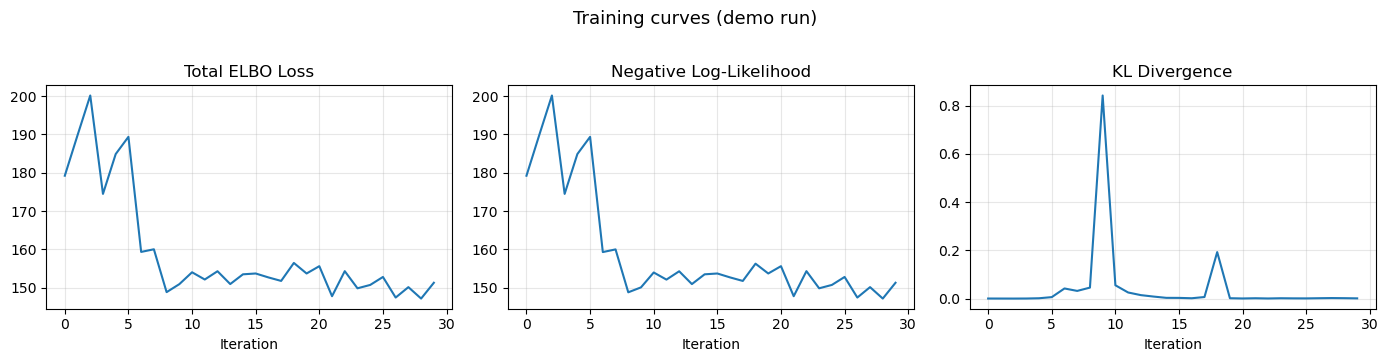

In [8]:
import matplotlib.pyplot as plt

df_log = pd.DataFrame(losses_log)

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))
for ax, col, title in zip(axes,
    ["loss", "neg_ll", "kl"],
    ["Total ELBO Loss", "Negative Log-Likelihood", "KL Divergence"]):
    ax.plot(df_log["iter"], df_log[col])
    ax.set_xlabel("Iteration")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

fig.suptitle("Training curves (demo run)", y=1.02, fontsize=13)
plt.tight_layout()
plt.show()

## 8 — Evaluation

During training, every 500 iterations the `Trainer` evaluates on the validation set:

1. **`run_batch_eval`** — randomly picks `num_context` points from the *target* set as context (simulating few-shot), then computes the loss.  Repeated for `num_context ∈ {0, 3, 5, 10}`.
2. **`run_batch_train`** — also computes the standard training loss on val batches for a comparable `val_loss`.
3. If `val_loss` improves (after iteration 1500), the model checkpoint is saved.

In [11]:
model.eval()
# Note: loss_func must stay in .train() mode — the Loss base class
# raises NotImplementedError in eval mode. The repo's Trainer.eval()
# also keeps the loss in train mode.
loss_func.train()

MAX_EVAL_BATCHES = 10
num_context_list = [0, 3, 5, 10] if config.min_num_context == 0 else [3, 5, 10]
eval_losses = {nc: [] for nc in num_context_list}

with torch.no_grad():
    for i, batch in enumerate(val_dl):
        (_, _), (xt_v, yt_v), know_v, _ = batch
        xt_v = xt_v.to(config.device)
        yt_v = yt_v.to(config.device)

        for nc in num_context_list:
            # Randomly pick nc context points from the target set
            ctx_idx = np.random.choice(xt_v.shape[1], nc, replace=False)
            xc_v = xt_v[:, ctx_idx, :]
            yc_v = yt_v[:, ctx_idx, :]

            # Sort context if configured
            if config.sort_context:
                xc_v, sidx = torch.sort(xc_v, dim=1)
                yc_v = torch.gather(yc_v, 1, sidx)

            know_input = know_v if config.use_knowledge else None
            out = model(xc_v, yc_v, xt_v, y_target=yt_v, knowledge=know_input)
            l, _, _ = loss_func(out, yt_v)
            eval_losses[nc].append(l.item())

        if i >= MAX_EVAL_BATCHES:
            break

print("=== Validation loss by num_context ===")
for nc, vals in eval_losses.items():
    print(f"  num_context={nc:2d}  →  loss = {np.mean(vals):.4f}")

=== Validation loss by num_context ===
  num_context= 0  →  loss = 150.3762
  num_context= 3  →  loss = 150.3677
  num_context= 5  →  loss = 150.3645
  num_context=10  →  loss = 150.3776


## 9 — Entry Point Summary

The full training is launched from `models/train.py` as:

```python
# 1. Load config
config = Config(**toml.load("config.toml"))

# 2. Set seeds
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# 3. Optuna study (default n_trials=1, so just one run)
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: meta_train(trial, config), n_trials=config.n_trials)
```

Inside `meta_train`:
- Creates a numbered save directory under `saves/{project_name}/`
- Instantiates `Trainer(config)` → builds dataloaders, model, optimizer, loss
- Saves `config.toml` into the run folder
- Initialises a W&B run
- Calls `trainer.train()` → epoch loop → batch loop → forward/backward/eval/checkpoint
- Returns best eval loss for Optuna

**Checkpointing:** best `model_best.pt` and `optim_best.pt` are saved whenever `val_loss` improves after iteration 1500.